In [1]:
!pip install statsmodels matplotlib seaborn pandas numpy


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'final_data')

REG_PATH = os.path.join(DATA_DIR, 'regression_dataset_sample.csv')
MET_PATH = os.path.join(DATA_DIR, 'performance_metrics_sample.csv')
TUNE_PATH = os.path.join(DATA_DIR, 'tuning_results_sample.csv')

print("샘플 데이터셋 로드")
df_reg = pd.read_csv(REG_PATH)
df_met = pd.read_csv(MET_PATH)
df_tune = pd.read_csv(TUNE_PATH) if os.path.exists(TUNE_PATH) else None

topic_cols = [col for col in df_reg.columns if col.startswith('topic_')]
feature_cols = ['doc_length', 'query_length'] + topic_cols

샘플 데이터셋 로드


In [3]:
def run_logit(model_name, subset_df):
    X = subset_df[feature_cols]
    y = subset_df['success']
    X = sm.add_constant(X)

    try:
        model = sm.Logit(y, X)
        result = model.fit(disp=0)

        df_res = pd.DataFrame({
            'Model': model_name,
            'Feature': result.params.index,
            'Odds Ratio': np.exp(result.params.values),
            'P-value': result.pvalues.values,
            'Lower CI': np.exp(result.conf_int()[0].values),
            'Upper CI': np.exp(result.conf_int()[1].values)
        })
        return df_res
    except Exception as e:
        print(f"Error in {model_name}: {e}")
        return pd.DataFrame()

print("\n로지스틱 회귀분석 수행")
res_bim = run_logit("BIM", df_reg[df_reg['model'] == 'BIM'])
res_bm25 = run_logit("BM25", df_reg[df_reg['model'] == 'BM25_Best'])

final_res = pd.concat([res_bim, res_bm25], ignore_index=True)
final_res = final_res[final_res['Feature'] != 'const']


로지스틱 회귀분석 수행


 [분석 1] a1: 문서 길이(doc_length)의 영향력


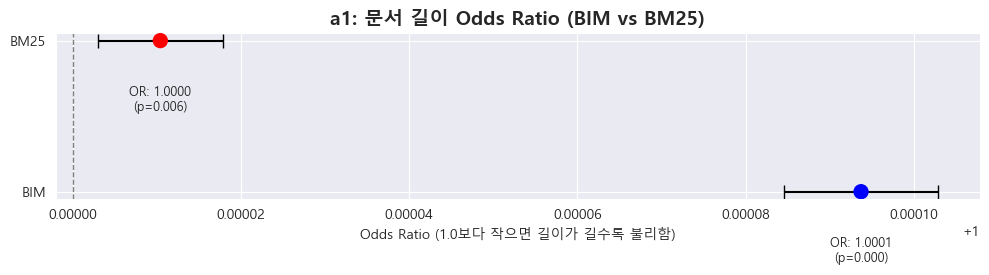

In [4]:
def plot_forest_comparison(data, feature_name, title, xlabel):
    subset = data[data['Feature'] == feature_name]

    plt.figure(figsize=(10, 3))
    y_pos = range(len(subset))

    err = [subset['Odds Ratio'] - subset['Lower CI'], subset['Upper CI'] - subset['Odds Ratio']]

    colors = ['blue' if m == 'BIM' else 'red' for m in subset['Model']]

    plt.errorbar(subset['Odds Ratio'], y_pos, xerr=err, fmt='o', capsize=5, color='black')
    plt.scatter(subset['Odds Ratio'], y_pos, c=colors, s=100, zorder=3)

    plt.axvline(x=1.0, color='gray', linestyle='--', linewidth=1)

    plt.yticks(y_pos, subset['Model'])
    plt.xlabel(xlabel)
    plt.title(title, fontsize=14, fontweight='bold')

    for i, (_, row) in enumerate(subset.iterrows()):
        plt.text(row['Odds Ratio'], i - 0.3, f"OR: {row['Odds Ratio']:.4f}\n(p={row['P-value']:.3f})",
                 ha='center', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()

print(" [분석 1] a1: 문서 길이(doc_length)의 영향력")
plot_forest_comparison(final_res, 'doc_length',
                       'a1: 문서 길이 Odds Ratio (BIM vs BM25)',
                       'Odds Ratio (1.0보다 작으면 길이가 길수록 불리함)')

 [분석 2] a2: 쿼리 길이(query_length)의 영향력


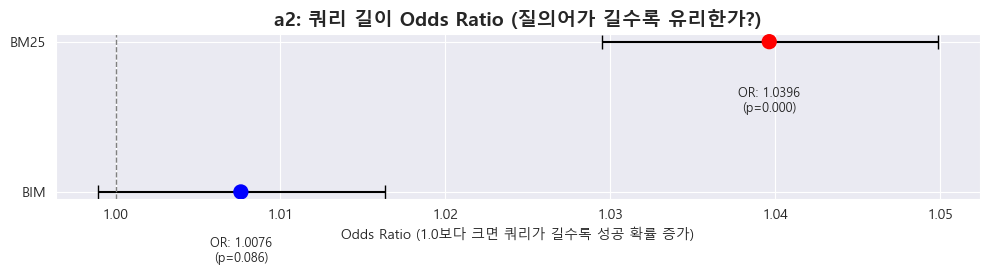

In [5]:
print(" [분석 2] a2: 쿼리 길이(query_length)의 영향력")
plot_forest_comparison(final_res, 'query_length',
                       'a2: 쿼리 길이 Odds Ratio (질의어가 길수록 유리한가?)',
                       'Odds Ratio (1.0보다 크면 쿼리가 길수록 성공 확률 증가)')

 [분석 3] a3: 도메인(Topic)별 검색 난이도 및 모델별 강점


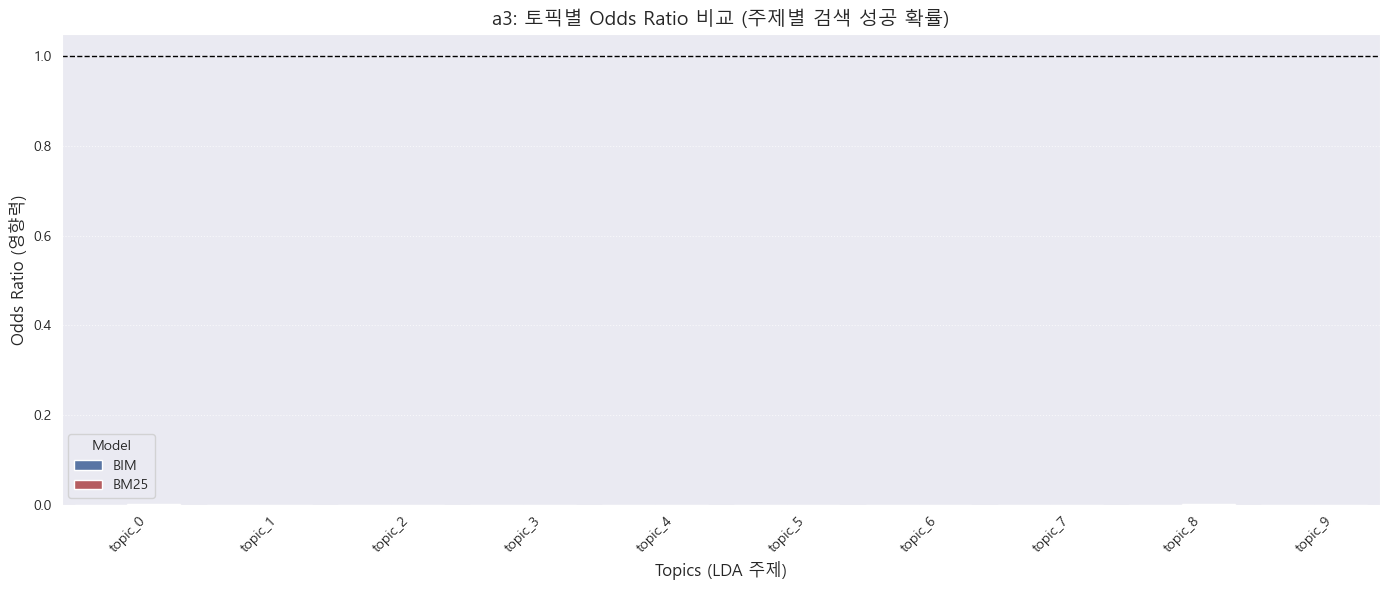

In [6]:
print(" [분석 3] a3: 도메인(Topic)별 검색 난이도 및 모델별 강점")

topic_res = final_res[final_res['Feature'].str.startswith('topic')].copy()

plt.figure(figsize=(14, 6))
sns.barplot(x='Feature', y='Odds Ratio', hue='Model', data=topic_res, palette=['#4c72b0', '#c44e52'])

plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
plt.title("a3: 토픽별 Odds Ratio 비교 (주제별 검색 성공 확률)", fontsize=14)
plt.xlabel("Topics (LDA 주제)", fontsize=12)
plt.ylabel("Odds Ratio (영향력)", fontsize=12)
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

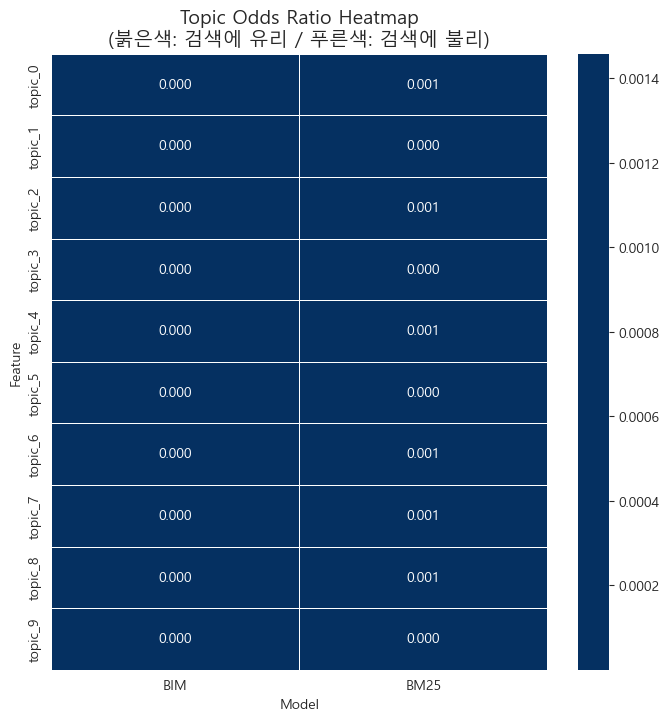

In [7]:
pivot_topics = topic_res.pivot(index='Feature', columns='Model', values='Odds Ratio')

plt.figure(figsize=(8, 8))
sns.heatmap(pivot_topics, annot=True, fmt=".3f", cmap="RdBu_r", center=1.0, linewidths=.5)
plt.title("Topic Odds Ratio Heatmap\n(붉은색: 검색에 유리 / 푸른색: 검색에 불리)", fontsize=14)
plt.show()

In [8]:
print("\n[해석 힌트]")
print("1. 문서 길이(a1): BM25의 OR이 1.0에 더 가까우면, '길이 정규화'가 잘 작동한 것입니다.")
print("2. 쿼리 길이(a2): OR > 1.0 이면, 구체적인(긴) 질문일수록 답을 잘 찾는다는 뜻입니다.")
print("3. 도메인(a3): Heatmap에서 붉은색이 진한 토픽은 해당 모델이 '잘 맞추는 주제'입니다.")
print("   - 만약 BIM은 푸른색인데 BM25가 붉은색인 토픽이 있다면, 그 주제에서 BM25의 성능 향상이 두드러진 것입니다.")


[해석 힌트]
1. 문서 길이(a1): BM25의 OR이 1.0에 더 가까우면, '길이 정규화'가 잘 작동한 것입니다.
2. 쿼리 길이(a2): OR > 1.0 이면, 구체적인(긴) 질문일수록 답을 잘 찾는다는 뜻입니다.
3. 도메인(a3): Heatmap에서 붉은색이 진한 토픽은 해당 모델이 '잘 맞추는 주제'입니다.
   - 만약 BIM은 푸른색인데 BM25가 붉은색인 토픽이 있다면, 그 주제에서 BM25의 성능 향상이 두드러진 것입니다.
